# [Sentiment Aanalysis on NAVER Movie Reviews]

## 1. Objective
The goal of this project is to create a sentiment analysis model that classifies the sentiment of sentences from NAVER movie reviews.

## 2. Description
"NAVER" is the most popular Korean website (a.k.a Korean version of Google). NAVER has provided movie information with "NAVER Moive" and People normally leave thier comments on there. 

In this project, I am going to scrap the reviews from random movies and classify the sentiment of the sentences from the reviews. I have coded this project model based on OOP (object oriented programming) and this project is focused on scrapping and modeling itselves. Hence, I am not going to take the standard process for data analysis but I am going to show you how I have created the model and how the model works with several test.

## 3. Modeling
There are six steps in this model. The step1, step2 and step3 are for data scrapping. The step4 and step5 are for data learning. Lastly, the step6 is for using the model.

### Import Libraries

In [3]:
# main.py
import requests
from bs4 import BeautifulSoup
from time import sleep
import pandas as pd
import os
from urllib import parse

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pickle
from konlpy.tag import *

### STEP 1
This step is to scrap the urls of detail page from the main page of NAVER Movie.


In [4]:
def step1_get_detail_url() :
    
    ## Assign the url that I am going to access to site
    site = 'https://movie.naver.com/movie/running/current.nhn?order=reserve'
    
    ## Access it.
    response = requests.get(site)
    bs = BeautifulSoup(response.content, 'html.parser')
    # print(bs)

    ## Bring 'a' tags
    a_list = bs.select('.top_thumb_lst a')

    ## Bring 'href' 
    df = pd.DataFrame()
    for idx in range(10) :
        href = a_list[idx].get('href')
        ## Create an object which analysed the address of href I brought
        a1 = parse.urlparse(href)
        ## Take the query string from a1 above (after "?")
        query_str = parse.parse_qs(a1.query)
        ## Take the parameter data out from the query string above.
        code = query_str['code'][0]
        print(code)

        # print(href)
        df = df.append([[code]], ignore_index=True)

    df.columns = ['code']
    df.to_csv('movie_code_list.csv', index=False, encoding='utf-8-sig')
    print('detail_url_completely_saved')

### STEP 2
This step is to scrap urls from the pages that we can see when we click the "more reviews" from the detail page.

In [5]:
def step2_get_reple_href() :
    
    ## Bring the codes that I've scrapped
    code_frame = pd.read_csv('movie_code_list.csv')
    code_list = code_frame['code'].tolist()

    ## For test
    code_list = ['156464', '109906']

    ## Create an url to request combining the movie code and the url
    url_list = pd.DataFrame()
    for code in code_list:
        site = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=%s&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false' % code
        # print(site)
        url_list = url_list.append([[site]], ignore_index=True)

    url_list.columns = ['url']
    url_list.to_csv('movie_url_list.csv', index=False, encoding='utf-8-sig')
    print('Completley Saved')

### STEP 3
This step is tos scrap the rates and the reviews with 140 chracters from page no.1 to the last page.

In [7]:
def step3_get_reply_data() :

    ## Bring the url data which has been saved as csv
    df = pd.read_csv('movie_url_list.csv')
    url_list = df['url'].tolist()

    # for url in url_list :
    #    print(url)
    # url = url_list[0]

    for url in url_list :
        print(url)
        ## Take the first html data from every single movie page
        response = requests.get(url)
        bs = BeautifulSoup(response.content, 'html.parser')
        # print(bs)
        ## Calculate the total pages
        strong = bs.select('.total em')
        score_total = int(strong[1].text.replace(',', ''))
        # print(score_total)
        pageCnt = score_total // 10
        if score_total % 10 > 0 :
            pageCnt += 1
        # print(pageCnt)

        ## Take the reviews with 140 chracters from page no.1 to the last page
        
        now_page = 1  ## current page

        # pageCnt = 5
        while now_page <= pageCnt :
            sleep(0.001)
            ## The url that I am going to request
            url2 = url + '&page=' + str(now_page)
            # print(url2)

            ## Take the reviews out
            response2 = requests.get(url2)
            bs2 = BeautifulSoup(response2.content, 'html.parser')

            result_df = pd.DataFrame()

            ## Bring the "li" tags
            lis = bs2.select('.score_result li')

            for obj in lis :
                ## The rate
                star_score = obj.select('.star_score em')[0].text
                ## The review with 140 chracters
                score_reple = obj.select('.score_reple p')[0].text
                # print(star_score)
                # print(score_reple)

                ## Save

                result_df = result_df.append([[score_reple, star_score]], ignore_index=True)

            if os.path.exists('star_score.csv') == False :
                result_df.columns = ['text', 'score']
                result_df.to_csv('star_score.csv', index=False, encoding='utf-8-sig')
            else :
                result_df.to_csv('star_score.csv', index=False, encoding='utf-8-sig', mode='a', header=False)

            print("%d / %d" % (now_page, pageCnt))
            now_page += 1

    print('Completely Saved')

### STEP 4
This step is to preprocess the data before we go on to learning stage.

In [8]:
## Data Preprocessing function for the reveiws with 140 characters 
def text_preprocessing(text) :
    if text.startswith('관람객') :
        return text[3:]
    else :
        return text

## Data preprocessing function for the rates
def star_preprocessing(text) :
    value = int(text)

    if value <= 5 :
        return '0'
    else :
        return '1'

def step4_data_preprocessing() :
    
    ## Read the data that I have scrapped
    df = pd.read_csv('star_score.csv')
    
    ## Do the preprocessing
    df['text'] = df['text'].apply(text_preprocessing)
    df['score'] = df['score'].apply(star_preprocessing)

    ## Split the data into train dataset and test dataset
    text_list = df['text'].tolist()
    star_list = df['score'].tolist()

    from sklearn.model_selection import train_test_split

    text_train, text_test, star_train, star_test = train_test_split(text_list, star_list, test_size=0.3, random_state=0)

    return text_train, text_test, star_train, star_test

### STEP 5
This step is for learning and saving the models.

In [9]:
## Morphological analysis function
def tokenizer(text) :
    okt = Okt()
    return okt.morphs(text)

def step5_learning(X_train, y_train, X_test, y_test):
    ## Create a dictionary with the data provided.
    ## Create an object that calcuates the word frequency and vectorise it
    tfidf = TfidfVectorizer(lowercase=False, tokenizer=tokenizer)
    logistic = LogisticRegression(C=10.0, penalty='l2', random_state=0)

    pipe = Pipeline([('vect', tfidf), ('clf', logistic)])

    ## Learn
    pipe.fit(X_train, y_train)

    ## Calculate accuracy score
    y_pred = pipe.predict(X_test)
    print(accuracy_score(y_test, y_pred))
    
    ## Save the model which is learned 
    with open('pipe.dat', 'wb') as fp :
        pickle.dump(pipe, fp)
        
    print('Completely Saved')

### STEP 6
This step is to use the model above.

In [10]:
def step6_using_model() :
    ## Restore the object
    with open('pipe.dat', 'rb') as fp:
        pipe = pickle.load(fp)

    import numpy as np

    while True :
        text = input('Please leave a review comment:')
        if text == "":
            
        
        str = [text]
        ## Prediction Accuracy
        r1 = np.max(pipe.predict_proba(str) * 100)
        ## Prediction result
        r2 = pipe.predict(str)[0]

        if r2 == '1' :
            print('Positive Review Comment')
        else :
            print('Negative Review Commnet')

        print('Accuracy : %.3f' % r1)

### Scrapping Function

In [11]:
def scrapping() :
    ## Get and save the movie code data
    step1_get_detail_url()
    ## Save the url of the page that has the review comments with 140 characters
    step2_get_reple_href()
    ## Get the review comments data
    step3_get_reply_data()

### Learning Function

In [12]:
def learning() :
    text_train, text_test, star_train, star_test = step4_data_preprocessing()
    step5_learning(text_train, star_train, text_test, star_test)

### Using Function

In [13]:
def using() :
    step6_using_model()

## Main

In [14]:
scrapping()

167699
164172
180372
152632
151153
156464
172187
171539
166092
164139
detail_url_completely_saved
Completley Saved
https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=156464&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false
1 / 3650
2 / 3650
3 / 3650
4 / 3650
5 / 3650
6 / 3650
7 / 3650
8 / 3650
9 / 3650
10 / 3650
11 / 3650
12 / 3650
13 / 3650
14 / 3650
15 / 3650
16 / 3650
17 / 3650
18 / 3650
19 / 3650
20 / 3650
21 / 3650
22 / 3650
23 / 3650
24 / 3650
25 / 3650
26 / 3650
27 / 3650
28 / 3650
29 / 3650
30 / 3650
31 / 3650
32 / 3650
33 / 3650
34 / 3650
35 / 3650
36 / 3650
37 / 3650
38 / 3650
39 / 3650
40 / 3650
41 / 3650
42 / 3650
43 / 3650
44 / 3650
45 / 3650
46 / 3650
47 / 3650
48 / 3650
49 / 3650
50 / 3650
51 / 3650
52 / 3650
53 / 3650
54 / 3650
55 / 3650
56 / 3650
57 / 3650
58 / 3650
59 / 3650
60 / 3650
61 / 3650
62 / 3650
63 / 3650
64 / 3650
65 / 3650
66 / 3650
67 / 3650
68 / 3650
69 / 3650
70 / 3650
71 / 3650
7

In [15]:
learning()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9073334192550586
Completely Saved


In [ ]:
using()

Please leave a review comment: 이 영화 좋아요


Positive Review Comment
Accuracy : 98.002


Please leave a review comment: 너무 재미없어


Negative Review Commnet
Accuracy : 90.384


Please leave a review comment: 이 영화 진짜 엄청 재밌어 대박이야


Positive Review Comment
Accuracy : 98.354


Please leave a review comment: 이렇게 재미없는 영화를 만들다니... 완전 쓰레기


Negative Review Commnet
Accuracy : 99.283


Please leave a review comment: 영화 좋아요 아주 좋아요


Positive Review Comment
Accuracy : 98.691


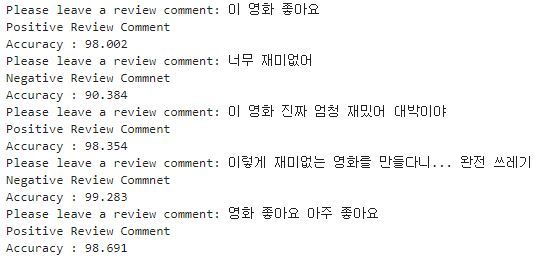

In [2]:
from IPython.display import Image
Image("Test_result.JPG")